# Basic RAG Application: Introduction to Haystack


## Environment Setup

In [1]:
import pandas as pd
pd.options.display.max_colwidth = 100

from my_secrets import get_secrets

In [2]:
secrets = get_secrets()
secrets.keys()

dict_keys(['gemini-api-key', 'pinecone-api-key', 'pinecone-index-name', 'pinecone-namespace'])

In [3]:
import google.generativeai as genai

genai.configure(api_key=secrets['gemini-api-key'])

In [4]:
df = pd.read_csv("data/refinedweb_generated_questions_v1.csv")
df.shape

(1000, 4)

In [5]:
df.head()

,document_id,documnet_text,generated_question,generated_answer
0,c0ac42a1-ecf9-5778-a3e2-b90382b6b4d7_0,"Jeet Thayil's 'Narcopolis', nominated to the Man Booker longlist, highlights many aspects of Mum...",What is the setting timeframe of Jeet Thayil's 'Narcopolis'?,"Mumbai in the 1970s, 80s, and 90s"
1,bd61923c-3652-550f-8ef9-88337e291335_0,"Scrum Techniques for Cross-Team Collaboration & Communication\nKelley Bevans, Information Techno...",What is Scrum commonly used for in the tech industry?,"Scrum is widely used in software development, consulting, and delivery."
2,5172c01b-2575-5a67-9f23-4cd823be1462_0,"e: 1. A transcendental constant with a value of 2.71828182846... represented by the letter e, fo...",What is the value of the mathematical constant e?,2.71828182846...
3,cea499c9-c1a1-57f8-8984-30dd891dffd3_0,Pan's Labyrinth: The Mythic Psyche Unveiled\nWhat follows is my initial review of the movie - I ...,What is the setting of Guillermo Del Toro's film Pan's Labyrinth?,Franco's Spain of the 1940s
4,f0c87da0-ba5e-5d78-b782-273e55ca5ed8_0,Vaikunda Ekadasi Uthsavam was celebrated grandly at Sri Parameswara Vinnagaram Divya Desams in K...,What is the name of the deity in the Velukkai Azhagiya Singar Temple who is in a sitting posture...,Azhagiya Singar


In [6]:
random_sample = df.sample(n=1, random_state=12)
#print(random_sample)
question = random_sample['generated_question'].values[0]
answer = random_sample['generated_answer'].values[0]
print(question)
print(answer)

What animal inspired scientists to develop a sound-dampening technology for use in wind turbines, airplane wings, and computer fans?
Owls


In [7]:
document_text = random_sample['documnet_text'].values[0]
document_text

'Owl-Inspired sound-minimization technology\nPicture source: creative commons\nHighlight: “As they swoop down on mice at night, the prey have no idea what’s coming. This is because owls are the experts of silent flight. By studying how the birds manage this stealthy feat, scientists have developed a sound-dampening technology that could be used to coat wind turbines, airplane wings, and even the fans of computers, to make them quieter.”\nInsight: Sound is an omnipresent pollution in modern society. While we tend to forget about it, people living in cities especially are constantly exposed to sounds of various intensity and long exposures have been linked to several health impacts.\nA lot of these sounds come from rotating parts and more precisely blades. It is surprising that the practice of design replication is common in the industrial business world even though it may not be the best. Most blades follow the same basic design without much customization when in fact it is obvious that

In [8]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(question)
print(response.text)

The **bowhead whale** inspired the development of sound-dampening technology for wind turbines, airplane wings, and computer fans.  Their baleen plates have unique structures that reduce the noise they generate while feeding.  Scientists studied these structures to develop similar designs for reducing noise in other applications.



## LLMs have limited knowledge and context

We use RAG to fill in gaps in knowledge for LLMs.

- [YouTube: What is RAG?](https://youtu.be/T-D1OfcDW1M?si=urS82tLAScxvvLRu) - Approx. 6 minutes

- [YouTube: How to use Retrieval Augmented Generation (RAG)](https://youtu.be/oVtlp72f9NQ?si=0BY_OLVczQ_ukw3f) - Approx. 7 minutes

- [YouTube: Advanced RAG techniques for developers](https://youtu.be/sGvXO7CVwc0?si=TXExECFC7LsuBrNC)


![rag-pipeline](rag-pipeline.jpeg)

## Pinecone Document Store

To install `pip install haystack-ai pinecone-haystack google-ai-haystack`
`

[Pinecone Document Store Documentation](https://docs.haystack.deepset.ai/reference/integrations-pinecone)

## Embeddings Model

[sentence-transformers/all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

In [9]:
## Downloading the embeddings model

# from sentence_transformers import SentenceTransformer

# model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2", cache_folder="sbert_models")

# model.save_pretrained(path="sbert_models/all-mpnet-base-v2", model_name="all-mpnet-base-v2")

In [10]:
## Importing the embeddings model

# from haystack import Document
# from haystack.components.embedders import SentenceTransformersDocumentEmbedder
# doc = Document(content="I love pizza!")
# doc_embedder = SentenceTransformersDocumentEmbedder(model="sbert_models/all-mpnet-base-v2")
# doc_embedder.warm_up()

# result = doc_embedder.run([doc])
# print(result['documents'][0].embedding)
# print(len(result['documents'][0].embedding))

# # 768 

In [11]:
from haystack.utils import Secret

from haystack.document_stores.types import DuplicatePolicy
from haystack import Document
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack_integrations.components.retrievers.pinecone import PineconeEmbeddingRetriever
from haystack_integrations.document_stores.pinecone import PineconeDocumentStore



/home/jonathan/miniconda3/envs/demo_chat/lib/python3.11/site-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(
/home/jonathan/miniconda3/envs/demo_chat/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [12]:
def row_to_doc(row):
    return Document(content=row['documnet_text'], id = row['document_id'])

In [13]:
documents = df.apply(row_to_doc, axis=1).tolist()
documents[0]

Document(id=c0ac42a1-ecf9-5778-a3e2-b90382b6b4d7_0, content: 'Jeet Thayil's 'Narcopolis', nominated to the Man Booker longlist, highlights many aspects of Mumbai'...')

In [14]:
## Define Document Store and Embedder
document_store = PineconeDocumentStore(
    index="udemy", namespace="basic_rag", 
    dimension=768, 
    api_key=Secret.from_token(secrets['pinecone-api-key']), 
    metric='cosine'
    )

document_embedder = SentenceTransformersDocumentEmbedder(model="sbert_models/all-mpnet-base-v2", progress_bar=True)
document_embedder.warm_up()

In [15]:
## Embed Documents
documents_with_embeddings = document_embedder.run(documents[:4]) # I've pre-uploaded so only doing 4 as a demo


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
## Upsert to Pinecone
document_store.write_documents(documents_with_embeddings.get("documents"), policy=DuplicatePolicy.OVERWRITE)

Upserted vectors:   0%|          | 0/4 [00:00<?, ?it/s]

4

## Test the Retriever

In [17]:
query_pipeline = Pipeline()
query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model="sbert_models/all-mpnet-base-v2", progress_bar=False))
query_pipeline.add_component("retriever", PineconeEmbeddingRetriever(document_store=document_store, top_k=10))
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

query = "What animal inspired scientists to develop a sound-dampening technology for use in wind turbines, airplane wings, and computer fans?"

search_results = query_pipeline.run({"text_embedder": {"text": query}})

In [18]:
assert search_results['retriever']['documents'][0].content == document_text

In [19]:
search_results['retriever']['documents'][0].content

'Owl-Inspired sound-minimization technology\nPicture source: creative commons\nHighlight: “As they swoop down on mice at night, the prey have no idea what’s coming. This is because owls are the experts of silent flight. By studying how the birds manage this stealthy feat, scientists have developed a sound-dampening technology that could be used to coat wind turbines, airplane wings, and even the fans of computers, to make them quieter.”\nInsight: Sound is an omnipresent pollution in modern society. While we tend to forget about it, people living in cities especially are constantly exposed to sounds of various intensity and long exposures have been linked to several health impacts.\nA lot of these sounds come from rotating parts and more precisely blades. It is surprising that the practice of design replication is common in the industrial business world even though it may not be the best. Most blades follow the same basic design without much customization when in fact it is obvious that

## Build the RAG Pipeline

In [20]:
from haystack.components.builders import PromptBuilder

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)


In [21]:
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator

gemini = GoogleAIGeminiGenerator(
    model="gemini-1.5-flash", 
    api_key=Secret.from_token(secrets['gemini-api-key'])
    )

In [22]:
text_embedder = SentenceTransformersTextEmbedder(model="sbert_models/all-mpnet-base-v2")

In [23]:
## initialize the pipeline
basic_rag_pipeline = Pipeline()


## add components to the pipline
basic_rag_pipeline.add_component("text_embedder", text_embedder)
basic_rag_pipeline.add_component("retriever", PineconeEmbeddingRetriever(document_store=document_store, top_k=20))
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", gemini)


## Connect the components
# Now, connect the components to each other
basic_rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")




🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: PineconeEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: GoogleAIGeminiGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.parts (str)

In [24]:
question

'What animal inspired scientists to develop a sound-dampening technology for use in wind turbines, airplane wings, and computer fans?'

In [25]:
response = basic_rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
print(response['llm']['replies'][0])

Owls.



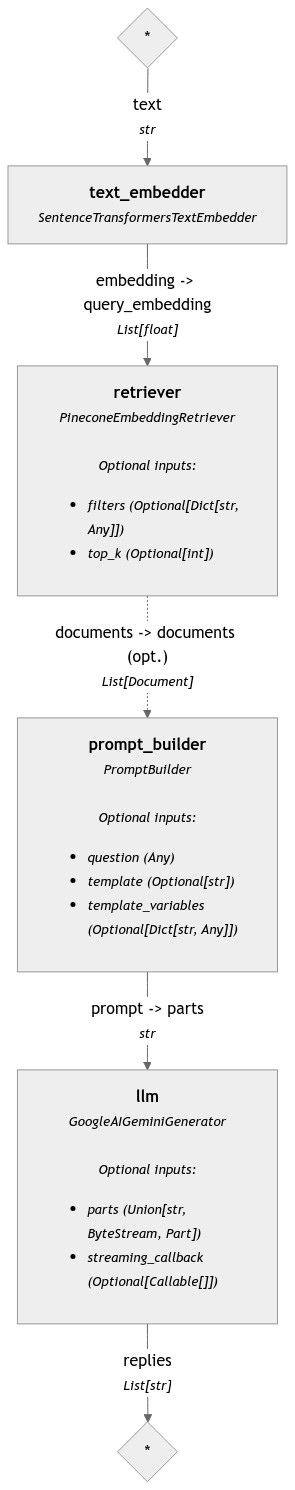

In [27]:
basic_rag_pipeline.show()